In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.metrics import MeanSquaredError
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.titlesize': 'large',
          'figure.figsize': (11, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [2]:
os.listdir('data')

['coin_Aave.csv',
 'coin_BinanceCoin.csv',
 'coin_Bitcoin.csv',
 'coin_Cardano.csv',
 'coin_ChainLink.csv',
 'coin_Cosmos.csv',
 'coin_CryptocomCoin.csv',
 'coin_Dogecoin.csv',
 'coin_EOS.csv',
 'coin_Ethereum.csv',
 'coin_Iota.csv',
 'coin_Litecoin.csv',
 'coin_Monero.csv',
 'coin_NEM.csv',
 'coin_Polkadot.csv',
 'coin_Solana.csv',
 'coin_Stellar.csv',
 'coin_Tether.csv',
 'coin_Tron.csv',
 'coin_Uniswap.csv',
 'coin_USDCoin.csv',
 'coin_WrappedBitcoin.csv',
 'coin_XRP.csv']

In [3]:
ROOT_PATH = 'data'

# Step 1: Define Problem
In this notebook we are going to build a RNN model for predicting crypto currency.

My target is Litecoin Closing Price in the next day. I choose LiteCoin because it fit my pocket : )

# Step 2: Data Understanding
The dataset we will use, was collected by Chennai, Tamil Nadu in Kaggle. You can get it from this link: https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory

## **Data Content**
The dataset has one csv file for each currency. Price history is available on a daily basis from April 28, 2013. This dataset has the historical price information of some of the top crypto currencies by market capitalization.

- Date : date of observation
- Open : Opening price on the given day
- High : Highest price on the given day
- Low : Lowest price on the given day
- Close : Closing price on the given day
- Volume : Volume of transactions on the given day
- Market Cap : Market capitalization in USD

# Step 3: Preprocessing Data

In [4]:
coin_dataframes = dict()

def date_format(date_str):
    return pd.to_datetime(date_str)


for fn in os.listdir(ROOT_PATH):
    coin_name = fn.split("_")[1][:-4]
    df = pd.read_csv(os.path.join(ROOT_PATH, fn), parse_dates=['Date'], dayfirst=True)
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    df = df.set_index('Date', drop=True)
    coin_dataframes[coin_name] = df.sort_values('Date')

In [5]:
coin_dataframes['Bitcoin'].tail()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2021-07-02,2987,Bitcoin,BTC,33939.58870,32770.68078,33549.60018,33897.04859,3.872897e+10,6.350000e+11
2021-07-03,2988,Bitcoin,BTC,34909.25990,33402.69654,33854.42136,34668.54840,2.438396e+10,6.500000e+11
2021-07-04,2989,Bitcoin,BTC,35937.56715,34396.47746,34665.56487,35287.77977,2.492431e+10,6.620000e+11
2021-07-05,2990,Bitcoin,BTC,35284.34443,33213.66103,35284.34443,33746.00246,2.672155e+10,6.330000e+11
2021-07-06,2991,Bitcoin,BTC,35038.53636,33599.91617,33723.50966,34235.19345,2.650126e+10,6.420000e+11


In [6]:
for key, data in coin_dataframes.items():
    print(f"Coin {key} with data's length: {data.shape[0]}")

Coin Aave with data's length: 275
Coin BinanceCoin with data's length: 1442
Coin Bitcoin with data's length: 2991
Coin Cardano with data's length: 1374
Coin ChainLink with data's length: 1385
Coin Cosmos with data's length: 845
Coin CryptocomCoin with data's length: 935
Coin Dogecoin with data's length: 2760
Coin EOS with data's length: 1466
Coin Ethereum with data's length: 2160
Coin Iota with data's length: 1484
Coin Litecoin with data's length: 2991
Coin Monero with data's length: 2602
Coin NEM with data's length: 2288
Coin Polkadot with data's length: 320
Coin Solana with data's length: 452
Coin Stellar with data's length: 2527
Coin Tether with data's length: 2318
Coin Tron with data's length: 1392
Coin Uniswap with data's length: 292
Coin USDCoin with data's length: 1002
Coin WrappedBitcoin with data's length: 888
Coin XRP with data's length: 2893


In [7]:
#We will drop coin with size < 2000
keys = [k for k, v in coin_dataframes.items() if v.shape[0] < 2000]
for x in keys:
    del coin_dataframes[x]
    
for key, data in coin_dataframes.items():
    print(f"Coin {key} with data's length: {data.shape[0]}")

Coin Bitcoin with data's length: 2991
Coin Dogecoin with data's length: 2760
Coin Ethereum with data's length: 2160
Coin Litecoin with data's length: 2991
Coin Monero with data's length: 2602
Coin NEM with data's length: 2288
Coin Stellar with data's length: 2527
Coin Tether with data's length: 2318
Coin XRP with data's length: 2893


In [8]:
#Get 2160 most recent records for each coin. For synchronizing training_set

for key, data in coin_dataframes.items():
    coin_dataframes[key] = coin_dataframes[key][-2160:]
    
for key, data in coin_dataframes.items():
    print(f"Coin {key} with data's length: {data.shape[0]}")

Coin Bitcoin with data's length: 2160
Coin Dogecoin with data's length: 2160
Coin Ethereum with data's length: 2160
Coin Litecoin with data's length: 2160
Coin Monero with data's length: 2160
Coin NEM with data's length: 2160
Coin Stellar with data's length: 2160
Coin Tether with data's length: 2160
Coin XRP with data's length: 2160


In [9]:
#Detect missing value

for key in coin_dataframes.keys():
    print(f"Coin {key} with total nan values:\n{coin_dataframes[key].isna().sum()} ")

Coin Bitcoin with total nan values:
SNo          0
Name         0
Symbol       0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64 
Coin Dogecoin with total nan values:
SNo          0
Name         0
Symbol       0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64 
Coin Ethereum with total nan values:
SNo          0
Name         0
Symbol       0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64 
Coin Litecoin with total nan values:
SNo          0
Name         0
Symbol       0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64 
Coin Monero with total nan values:
SNo          0
Name         0
Symbol       0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64 
Coin NEM with total nan values:
SNo          0
Name         0
Symbol     

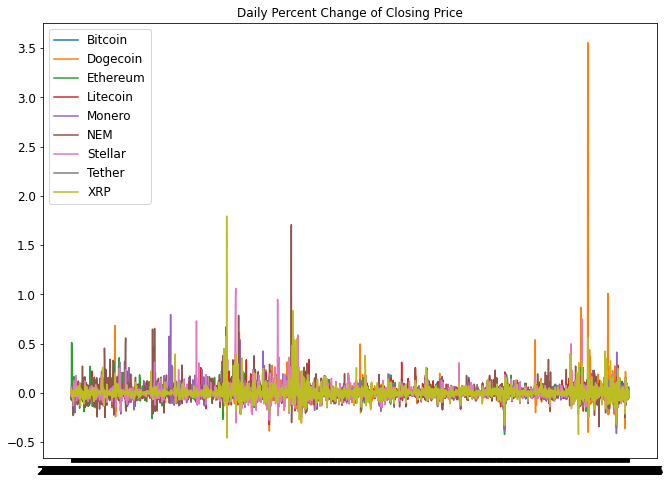

In [10]:

# Percent Change Closing Price Per Day for each Coin
for coin in coin_dataframes.keys():
    coin_dataframes[coin]['ClosePctChg'] = coin_dataframes[coin]['Close'].pct_change().fillna(0)
    
for coin in coin_dataframes.keys():
    plt.plot(coin_dataframes[coin]['ClosePctChg'], label=coin)
plt.legend(loc=2)
plt.title('Daily Percent Change of Closing Price')
plt.show()

In [11]:
# See their correlation
data = pd.DataFrame()

for k, v in coin_dataframes.items():
    data[k] = v['ClosePctChg']

corrmat = data.corr()

corrmat

,Bitcoin,Dogecoin,Ethereum,Litecoin,Monero,NEM,Stellar,Tether,XRP
Bitcoin,1.000000,0.335172,0.515587,0.649799,0.535185,0.381678,0.396056,-0.008574,0.344906
Dogecoin,0.335172,1.000000,0.241976,0.328242,0.241430,0.205893,0.309309,-0.017885,0.250149
Ethereum,0.515587,0.241976,1.000000,0.502817,0.441758,0.325970,0.339368,-0.007316,0.309339
Litecoin,0.649799,0.328242,0.502817,1.000000,0.482823,0.400920,0.417873,-0.025426,0.409793
Monero,0.535185,0.241430,0.441758,0.482823,1.000000,0.311696,0.382610,-0.021276,0.301566
NEM,0.381678,0.205893,0.325970,0.400920,0.311696,1.000000,0.390143,-0.045381,0.297554
Stellar,0.396056,0.309309,0.339368,0.417873,0.382610,0.390143,1.000000,0.002146,0.544366
Tether,-0.008574,-0.017885,-0.007316,-0.025426,-0.021276,-0.045381,0.002146,1.000000,-0.021132
XRP,0.344906,0.250149,0.309339,0.409793,0.301566,0.297554,0.544366,-0.021132,1.000000


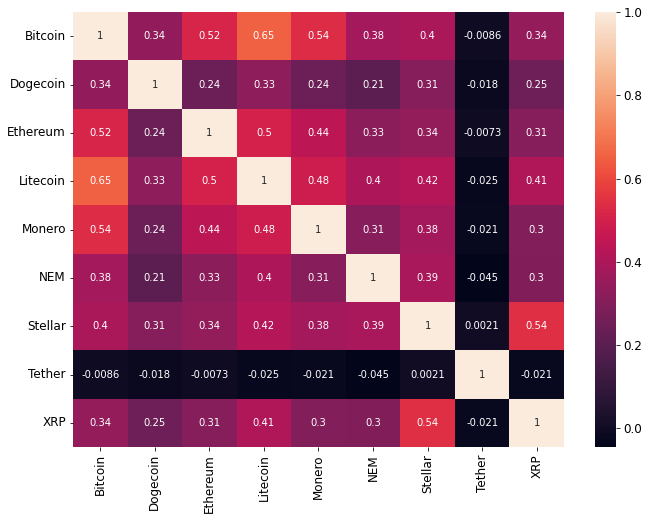

In [12]:
#Plot the corrmat
sns.heatmap(corrmat, annot=True);

In [13]:
coin_dataframes['Litecoin'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap,ClosePctChg
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2.160000e+03,2.160000e+03,2160.000000
mean,1911.500000,68.301917,62.475240,65.535192,65.578829,1.777760e+09,3.990192e+09,0.003285
std,623.682612,71.261533,63.337469,67.569113,67.538078,2.474449e+09,4.211432e+09,0.058109
min,832.000000,2.724670,2.543790,2.638140,2.633140,5.074800e+05,1.109224e+08,-0.361773
25%,1371.750000,4.241605,4.073073,4.160737,4.162520,7.898028e+06,2.025372e+08,-0.019902
50%,1911.500000,50.926489,47.456308,49.009223,49.080577,4.702091e+08,3.022224e+09,-0.000326
75%,2451.250000,86.438524,80.475550,83.439597,83.572502,2.851648e+09,5.015291e+09,0.022788
max,2991.000000,412.960141,345.298839,387.869178,386.450779,1.799426e+10,2.579652e+10,0.667653


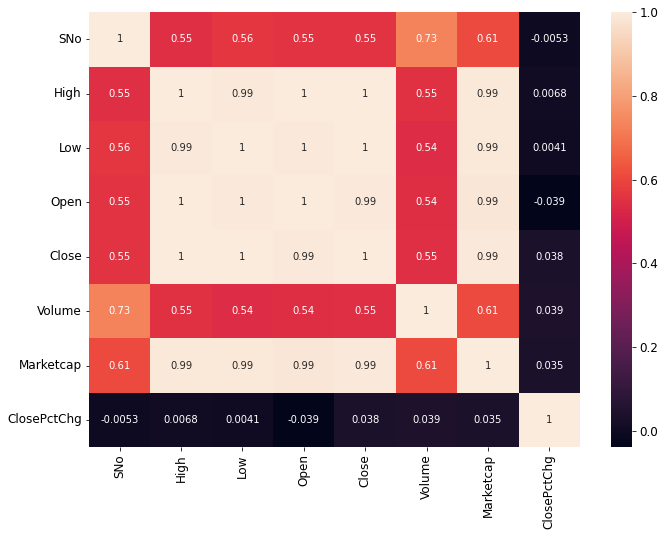

In [14]:
#Which features has most correlation with Ethereum Close Price
corrmat = coin_dataframes['Litecoin'].corr()
sns.heatmap(corrmat, annot=True);

In [15]:
#Select best coins have most correlation with Ethereum Closing Price
dataset = pd.DataFrame()
for k in coin_dataframes.keys():
    if k in ['Litecoin', 'Bitcoin']:
        for col in coin_dataframes[k].columns:
            if col in ['Open', 'Close', 'High', 'Low']: 
                dataset[k+'_'+col] = coin_dataframes[k][col]
        
dataset.tail()

,Bitcoin_High,Bitcoin_Low,Bitcoin_Open,Bitcoin_Close,Litecoin_High,Litecoin_Low,Litecoin_Open,Litecoin_Close
Date,,,,,,,,
2021-07-02,33939.58870,32770.68078,33549.60018,33897.04859,138.787700,130.935471,137.299274,136.943696
2021-07-03,34909.25990,33402.69654,33854.42136,34668.54840,141.356011,134.945288,136.930584,140.279688
2021-07-04,35937.56715,34396.47746,34665.56487,35287.77977,147.836059,137.096427,140.317998,144.905849
2021-07-05,35284.34443,33213.66103,35284.34443,33746.00246,144.849333,134.960263,144.849333,138.073246
2021-07-06,35038.53636,33599.91617,33723.50966,34235.19345,142.703568,135.924837,137.951668,138.985636


In [16]:
#Split train test
training_set = dataset[:2000].copy()
test_set = dataset[2000:].copy()

training_set.shape, test_set.shape

((2000, 8), (160, 8))

In [17]:
#Log transform data
for col in training_set.columns:
    training_set.loc[:,col] = np.log1p(training_set[col])
    test_set.loc[:, col] = np.log1p(test_set[col])

#Scaling data
scaler= MinMaxScaler(feature_range=(0,1))
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)



In [18]:
target = 'Litecoin_Close'
target_index = list(dataset.columns).index(target)
target_index

7

In [19]:
# Create sequences input data
X_train = []
y_train = []
window_size = 14
time_step_future = 7

for i in range(window_size, len(training_set)- time_step_future):
    
    #Make output data. There are three output, one is the yester day price, two is current_day price and three is closing price of time_step_future days later
    #RNN is a bit slowly react to the trend of coin. So i let it looks up far more into future, for well adapted model.
    t = []
    t.append(training_set[i-1, target_index])
    t.append(training_set[i, target_index])
    t.append(training_set[i+time_step_future, target_index])
    y_train.append(t)
    
    
    #Create X train data
    X_train.append(training_set[i-window_size:i, :])



X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

        
                

((1979, 14, 8), (1979, 3))

# Step 4: Building model

In [20]:
#Init rnn
regressor = Sequential()

#Adding first layer LSTM
regressor.add(Bidirectional( LSTM(units=50, return_sequences=True, input_shape=(window_size,X_train.shape[2])) ) )
regressor.add(Dropout(0.3))

#Adding second layer LSTM
regressor.add(LSTM(units=50, return_sequences=True)) 
regressor.add(Dropout(0.3))

#Adding third layer LSTM
regressor.add( LSTM(units=50) )
regressor.add(Dropout(0.3))

#Adding fourth layer LSTM
#regressor.add(LSTM(units=86))
#regressor.add(Dropout(0.2))

#Adding fifth layers LSTM
#regressor.add(LSTM(units = 64))
#regressor.add(Dropout(0.2))

#Adding output layers
regressor.add(Dense(units=3, activation = 'relu'))

#regressor.summary()

In [21]:
#Complie RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

### Fitting to training_set

In [22]:
regressor.fit(x = X_train, y = y_train, epochs=120, batch_size=32)

Epoch 1/120
62/62 [==============================] - 1s 12ms/step - loss: 0.0355
Epoch 2/120
62/62 [==============================] - 1s 12ms/step - loss: 0.0087
Epoch 3/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0079
Epoch 4/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0078
Epoch 5/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0067
Epoch 6/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 7/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 8/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 9/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 10/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 11/120
62/62 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 12/120
62/62 [==============================] - ETA: 0s - loss: 0.0043- ETA: 0s -  - 1s 11ms/step - l

# Step 5: Evaluation model


In [23]:
X_train.shape

(1979, 14, 8)

In [24]:
def unscale_y(y_pred):
    t = np.zeros(shape=(len(y_pred), X_train.shape[2]))
    t[:, target_index] = y_pred
    t = scaler.inverse_transform(t)[:, target_index]
    t = np.expm1(t)
    return t

In [25]:
#Get predicted closing price on training set for three output, and unscale them
y_pred = regressor.predict(X_train)
y_pred_yesterday = unscale_y(y_pred[:,0])
y_pred_current_day = unscale_y(y_pred[:,1])
y_pred_next_week = unscale_y(y_pred[:,2])

y_pred_next_week.shape, y_pred_yesterday.shape, y_pred_current_day.shape

((1979,), (1979,), (1979,))

In [26]:
#Get real closing price on training set
y_real_yesterday = dataset[window_size-1:2000-time_step_future-1][target].values
y_real_current_day = dataset[window_size:2000-time_step_future][target].values
y_real_next_week = dataset[window_size+time_step_future:2000][target].values

y_real_next_week.shape, y_real_yesterday.shape, y_real_current_day.shape


((1979,), (1979,), (1979,))

In [27]:
def make_plot_evaluation(y_real, y_pred, title):
    # Visualising the results
    plt.plot(y_real, color = 'red', label = 'Real  Closing Price')

    plt.plot(y_pred, color = 'blue', label = 'Predict  Closing Price')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

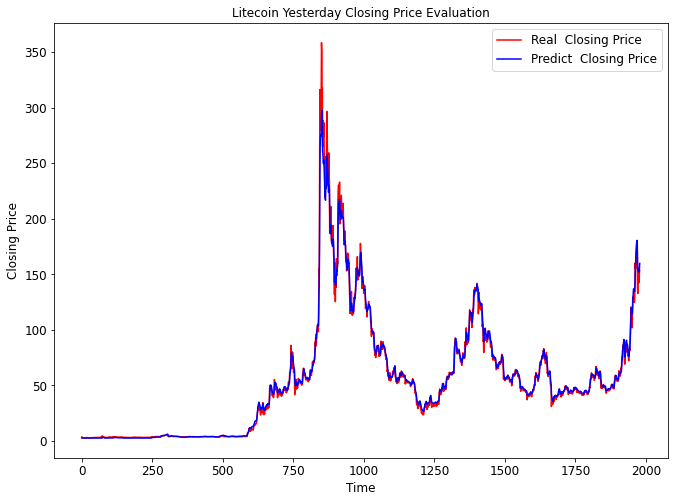

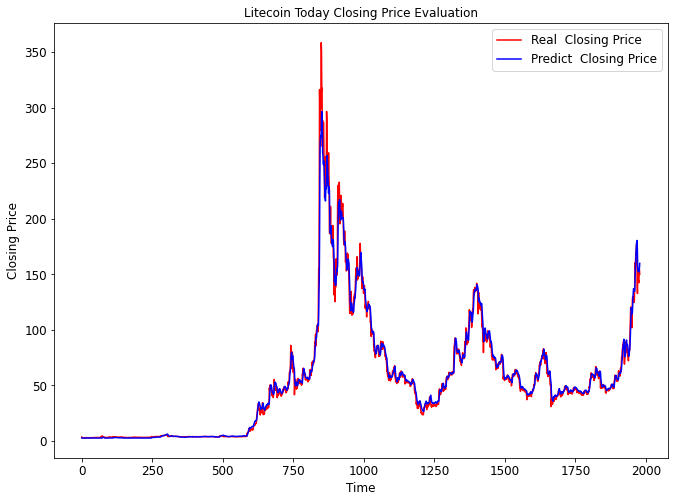

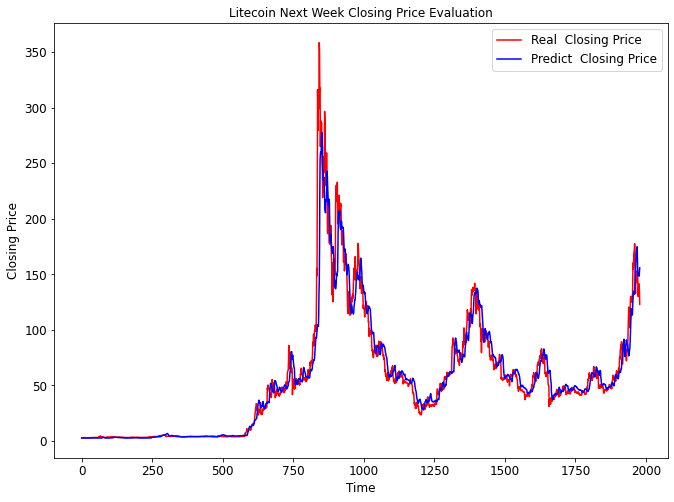

In [28]:
make_plot_evaluation(y_real_yesterday, y_pred_yesterday, 'Litecoin Yesterday Closing Price Evaluation')
make_plot_evaluation(y_real_current_day, y_pred_current_day, 'Litecoin Today Closing Price Evaluation')
make_plot_evaluation(y_real_next_week, y_pred_next_week, 'Litecoin Next Week Closing Price Evaluation')

## Evalution on test_set

In [29]:
test_set.shape

(160, 8)

In [30]:
#Generate test set
inputs = dataset[dataset.shape[0] - test_set.shape[0] - window_size: ].values
inputs = np.log1p(inputs)
inputs = scaler.transform(inputs)

In [31]:

# Create sequences input data
X_test = []

for i in range(window_size, len(inputs)-time_step_future):
    X_test.append(inputs[i-window_size:i, :])



X_test = np.array(X_test)
X_test.shape

(153, 14, 8)

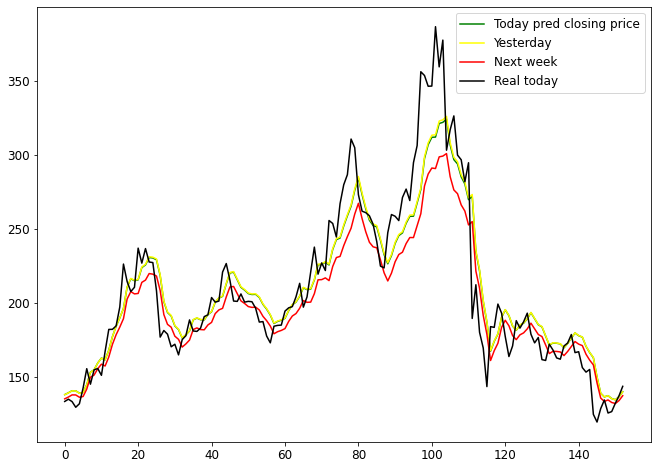

In [32]:
#Get predicted values
y_pred = regressor.predict(X_test)
y_pred_yesterday = unscale_y(y_pred[:,0])
y_pred_current_day = unscale_y(y_pred[:,1])
y_pred_next_week = unscale_y(y_pred[:,2])
#Get real values
y_real_yesterday = dataset[2000-1:-time_step_future-1][target].values
y_real_current_day = dataset[2000:-time_step_future][target].values
y_real_next_week = dataset[time_step_future+2000: ][target].values

# Visualising the results
plt.plot(y_pred_current_day, color = 'green', label='Today pred closing price')
plt.plot(y_pred_yesterday, color = 'yellow', label = 'Yesterday')
plt.plot(y_pred_next_week, color = 'red', label = 'Next week')
plt.plot(y_real_current_day, color = 'black', label ='Real today')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f"Mean square error on test: {mean_squared_error(y_pred=y_pred_current_day, y_true=y_real_current_day)}")
print(f"Mean absolute error on test: {mean_absolute_error(y_pred=y_pred_current_day, y_true=y_real_current_day)}")
print(f"R2 score on test: {r2_score(y_pred=y_pred_current_day, y_true=y_real_current_day)}")

Mean square error on test: 434.54159528302716
Mean absolute error on test: 14.613210770321981
R2 score on test: 0.8664318678271877


# Let run simulation of selling and buying coin with this model.

Let say I invest 2000$ for this time. And after 160 days, how much money i will get, or i lose them all?

In [34]:
X_train.shape

(1979, 14, 8)

In [35]:
import math
#Create a predict function
def predict_closing_price(model, X):
    X = np.reshape(X, (1, window_size, X_train.shape[2]))
    y_pred = model.predict(X)
    y_pred[:,0] = unscale_y(y_pred[:,0])
    y_pred[:,1] = unscale_y(y_pred[:,1])
    y_pred[:,2] = unscale_y(y_pred[:,2])
    
    return y_pred
    
#Create buy coin function
def buy_coin(price, number_coin):
    global MY_POCKET
    global COIN_I_HAVE
    if number_coin == 0:
        return 
    
    MY_POCKET = MY_POCKET - price*number_coin
    COIN_I_HAVE += number_coin
    
#Create a function to calculate total coin i can buy with percent loss of my pocket
def how_many_coin_buy(today_price, accpet_loss = 0.2):
    if MY_POCKET*accpet_loss < today_price:
        if MY_POCKET*0.5 >= today_price:
             return MY_POCKET*0.5//today_price
        elif MY_POCKET >= today_price:
            return 1
        else: 
            return 0
    else:
        return MY_POCKET*accpet_loss//today_price
    
    
    
#Create sell coin function
def sell_coin(closing_price, number_coin):
    global MY_POCKET
    global COIN_I_HAVE
    MY_POCKET += closing_price*number_coin
    COIN_I_HAVE -= number_coin

    



In [36]:
SIMULATION_MARKET = dataset[2000-1:]
SIMULATION_MARKET.shape

(161, 8)

In [37]:
MY_POCKET = 2000
COIN_I_HAVE = 0
i = 1

total_win, total_lose = 0,0
last_open_price_bought = 0

#Create a report
row = 0
report = pd.DataFrame(columns = ['MoneyInPocket', 'CoinsInPocket', 'CoinsBuy', 'CoinsSell', 'PctChangeToday', 'Profit'], 
                      dtype = 'float64' )

for today in SIMULATION_MARKET.iterrows():
    if (i >= X_test.shape[0]):
        break 
    
    print(f"Day {i}:")
    tomorrow_closing_price = predict_closing_price(regressor, X_test[i])[:,1]
    today_closing_price = predict_closing_price(regressor, X_test[i-1])[:,1]
    diff_today_tomorrow = tomorrow_closing_price - today_closing_price
    
    pct_today_tomorrow = diff_today_tomorrow/today_closing_price
    
    number_coins_buy, number_coins_sell = 0, 0
    #If next day the price growing up, buy
    if pct_today_tomorrow >= 0.0025:
        number_coins_buy = how_many_coin_buy(accpet_loss=0.5, today_price=today[1][6])
        buy_coin(number_coin=number_coins_buy, price=today[1][target_index])
    
    #If next day the price down, sell
    if pct_today_tomorrow <= 0.0015:
        number_coins_sell = math.ceil(0.7*COIN_I_HAVE)
        sell_coin(number_coin=number_coins_sell, closing_price=today[1][target_index])
    
    #Make a report for today 
    report.loc[row, 'MoneyInPocket'] = MY_POCKET + COIN_I_HAVE * today[1][target_index]
    report.loc[row, 'CoinsInPocket'] = COIN_I_HAVE
    report.loc[row, 'CoinsBuy'] = number_coins_buy
    report.loc[row, 'CoinsSell'] = number_coins_sell
    report.loc[row, 'PctChangeToday'] = pct_today_tomorrow

    
    if i > 2:
        profit = MY_POCKET + COIN_I_HAVE * today[1][target_index] - report.loc[row-1, 'MoneyInPocket']
    else:
        profit = 0
        
    if profit > 0:
        print(f"Win today total profit: {profit}")
    elif profit < 0:
        print(f"Lose today total loss: {profit}")
    
    print(f"Today decide to buy {number_coins_buy} and sell {number_coins_sell} coins. Coins remain in pocket {COIN_I_HAVE}")
        
    report.loc[row, 'Profit'] = profit
    
    print("")
    row+=1
    i+=1


Day 1:
Today decide to buy 7.0 and sell 0 coins. Coins remain in pocket 7.0

Day 2:
Today decide to buy 4.0 and sell 0 coins. Coins remain in pocket 11.0

Day 3:
Win today total profit: 16.782036810000136
Today decide to buy 0 and sell 8 coins. Coins remain in pocket 3.0

Day 4:
Lose today total loss: -4.837658099999771
Today decide to buy 0 and sell 3 coins. Coins remain in pocket 0.0

Day 5:
Today decide to buy 7.0 and sell 0 coins. Coins remain in pocket 7.0

Day 6:
Win today total profit: 16.667817040000045
Today decide to buy 4.0 and sell 0 coins. Coins remain in pocket 11.0

Day 7:
Win today total profit: 116.10547256000018
Today decide to buy 2.0 and sell 0 coins. Coins remain in pocket 13.0

Day 8:
Win today total profit: 170.36575309000045
Today decide to buy 1.0 and sell 0 coins. Coins remain in pocket 14.0

Day 9:
Lose today total loss: -146.49384246000045
Today decide to buy 1 and sell 0 coins. Coins remain in pocket 15.0

Day 10:
Win today total profit: 145.5604297499999
T

In [38]:
report.describe()

,MoneyInPocket,CoinsInPocket,CoinsBuy,CoinsSell,PctChangeToday,Profit
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,6614.513354,12.993421,3.480263,3.013158,0.000646,66.895979
std,3297.272985,14.233389,7.916761,7.405016,0.032981,223.217123
min,2000.000000,0.000000,0.000000,0.000000,-0.137379,-445.823668
25%,3692.274756,0.750000,0.000000,0.000000,-0.016258,-6.289507
50%,5847.483289,11.000000,0.000000,0.000000,0.003935,0.000000
75%,9493.755317,19.000000,3.000000,1.000000,0.024438,145.511698
max,12241.950967,71.000000,49.000000,42.000000,0.075779,1195.261801


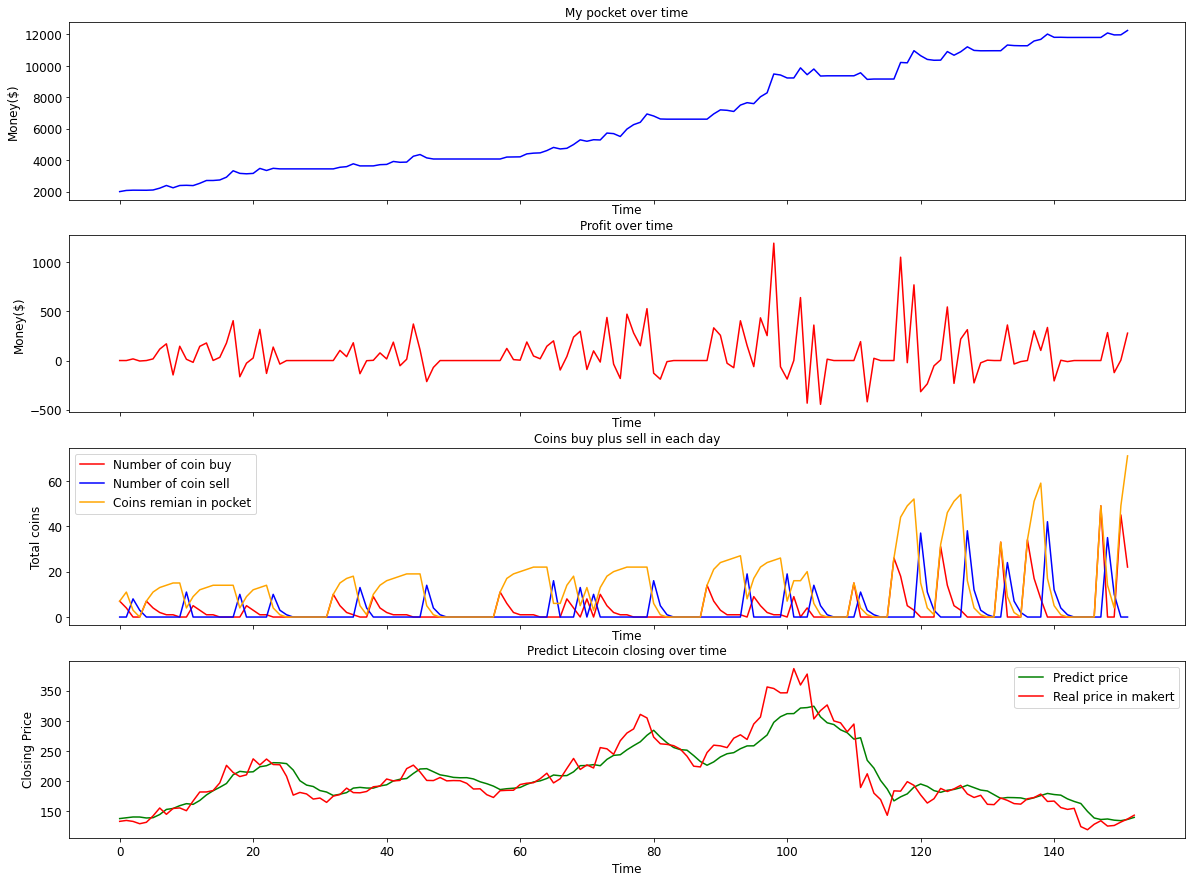

In [39]:
f, ax = plt.subplots(4, 1, sharex=True, figsize=(20,15))

#Plot my pocket
ax[0].plot(report['MoneyInPocket'], color = 'blue')
ax[0].set_title('My pocket over time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Money($)')

#Plot loss each day
ax[1].plot(report['Profit'], color = 'red')
ax[1].set_title("Profit over time")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Money($)')

#Plot coins track sell and buy in each day
ax[2].plot(report['CoinsBuy'], color = 'red', label='Number of coin buy')
ax[2].plot(report['CoinsSell'], color = 'blue', label='Number of coin sell')
ax[2].plot(report['CoinsInPocket'], color = 'orange', label='Coins remian in pocket')
ax[2].set_title("Coins buy plus sell in each day")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Total coins')
ax[2].legend()

#Plot predicted value
ax[3].plot(y_pred_current_day, color = 'green', label = "Predict price")
ax[3].plot(y_real_current_day, color = 'red', label = "Real price in makert")
ax[3].set_title("Predict Litecoin closing over time")
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Closing Price')
ax[3].legend()


plt.legend()
plt.show()


In [40]:
SIMULATION_MARKET.tail()

,Bitcoin_High,Bitcoin_Low,Bitcoin_Open,Bitcoin_Close,Litecoin_High,Litecoin_Low,Litecoin_Open,Litecoin_Close
Date,,,,,,,,
2021-07-02,33939.58870,32770.68078,33549.60018,33897.04859,138.787700,130.935471,137.299274,136.943696
2021-07-03,34909.25990,33402.69654,33854.42136,34668.54840,141.356011,134.945288,136.930584,140.279688
2021-07-04,35937.56715,34396.47746,34665.56487,35287.77977,147.836059,137.096427,140.317998,144.905849
2021-07-05,35284.34443,33213.66103,35284.34443,33746.00246,144.849333,134.960263,144.849333,138.073246
2021-07-06,35038.53636,33599.91617,33723.50966,34235.19345,142.703568,135.924837,137.951668,138.985636


In [41]:
print(f"After 160 days, total coins remain in pocket {COIN_I_HAVE}, total profit is {MY_POCKET + COIN_I_HAVE*138.9856 - 2000}")

After 160 days, total coins remain in pocket 71.0, total profit is 10713.22825731


Not bad with a simple custom strategy, which total profit is 10713$. With that money, some of us can buy some ice cream to eat this month.

I'm just playing with this, maybe it do not work quite well in real market. You should have to test it more for more trust able result. Please fell free to comment bellow if you find anything, or find any bug in my code. Thanks for reading!!

In [42]:
#Save model
regressor.save('LiteCoinModel.h5')